# Analysis of Domestic Terror Web Network

In [1]:
import networkx as nx
import networkx.algorithms.community as nxcom
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.kclique import k_clique_communities
import matplotlib.pyplot as plt
from datetime import datetime
import community
import csv
import operator

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
#plt.style.use('dark_background')
# get reproducible results
import random
from numpy import random as nprand
random.seed(123)
nprand.seed(123)

## Functions

In [2]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

In [3]:
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    edge_list = {}  # This dictionary store vlues of community with node
    inner_edges = {} # This dictionary store internal edges of each community
    degree_list = {} # This dictionary store total degree of each nodes in communities 
    node_edges_internal = {} # This dictionary store internal degree of each nodes in communities 
    node_edges_external = {} # This dictionary store external degree of each nodes in community with other communities
    for v, w, in G.edges:
        if 'community' not in G.nodes[v]:
            G.nodes[v]['community'] = 0
        if 'community' not in G.nodes[w]:
            G.nodes[w]['community'] = 0
        
        v_com = G.nodes[v]['community']
        w_com = G.nodes[w]['community']
        
        if v_com not in edge_list:
            edge_list[v_com] = [0,0]
            inner_edges[v_com] = []
            degree_list[v_com] = {}
            node_edges_internal[v_com] = {}
            node_edges_external[v_com] = {}
            
        if w_com not in edge_list:
            edge_list[w_com] = [0,0]
            inner_edges[w_com] = []
            degree_list[w_com] = {}
            node_edges_internal[w_com] = {}
            node_edges_external[w_com] = {}
        
        if v not in degree_list[v_com]:
            degree_list[v_com][v] = 0
            node_edges_internal[v_com][v] = 0
            node_edges_external[v_com][v] = {}
            
        if w not in degree_list[w_com]:
            degree_list[w_com][w] = 0
            node_edges_internal[w_com][w] = 0
            node_edges_external[w_com][w] = {}
        
        if v_com not in node_edges_external[w_com][w]:
            node_edges_external[w_com][w][v_com] = 0
        
        if w_com not in node_edges_external[v_com][v]:
            node_edges_external[v_com][v][w_com] = 0
                
        if v_com == w_com:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = v_com
            edge_list[v_com][0] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_internal[v_com][v] += 1
            node_edges_internal[w_com][w] += 1
            inner_edges[v_com].append(str(v)+" "+str(w))
            
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
            edge_list[v_com][1] +=1
            edge_list[w_com][1] +=1
            degree_list[v_com][v] +=1
            degree_list[w_com][w] +=1
            node_edges_external[v_com][v][w_com] += 1
            node_edges_external[w_com][w][v_com] += 1
    return edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges

In [4]:
def findExternalMax(node_edges_external):
    # Find the max external degree for each node to other community 
    max_edges = {}
    for i in node_edges_external:
        data = {"nodes":{}}
        max_edge = 0
        max_node = 0
        max_community = 0
        nodes = node_edges_external[i]
        for n in nodes:
            c_e = nodes[n]
            c_e = sorted(c_e.items(), key=operator.itemgetter(1), reverse=True)
            
            if max_edge<c_e[0][1]:
                max_edge = c_e[0][1]
                max_node = n
                max_community = c_e[0][0]
            data["nodes"][n] = c_e[0]
        data["max_external_edge"]= max_edge
        data["node"]= max_node
        data["external_community"]= max_community
        max_edges[i]= data
    return max_edges

In [5]:
def findingCoefficient(g):
    return nx.clustering(g)

def getCoefficient(community_inner_edges):
    # Calculating Clustering coefficient
    coefficient = {}
    for i in community_inner_edges:
        
        G = nx.parse_edgelist(inner_edges[i], nodetype = str) 
        #nx.parse_edgelist(inner_edges[i], nodetype = int, create_using=nx.DiGraph())
        # Draw network
        poss = nx.spring_layout(G, k=0.1)
        nx.draw_networkx(G, pos=poss, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=True)
        plt.show()
        coefficient[i] = findingCoefficient(G)
    return coefficient

In [6]:
def calculatePermanence(node_edges_internal, external_edges, degree_list, coefficient):
    permanence = {}
    for community in coefficient:
        permanence[community] = {}
        for i in coefficient[community]:
            if (external_edges[community]['nodes'][str(i)][1]):
                k = external_edges[community]['nodes'][str(i)][1]*degree_list[community][str(i)]
                perm = (node_edges_internal[community][str(i)]/(k)) - (1-coefficient[community][i])
            else:
                perm = coefficient[community][i]
            permanence[community][i] = perm
            
    return permanence

In [7]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b) 

## Load dataset


In [8]:
data_path = 'data/email-Eu-core.txt'

In [9]:
edge_data  = []
with open('data/DOMESTICTERRORWEB.csv') as datafile:
    data = csv.reader(datafile, delimiter=',')
    header = next(data)
    for j, row in enumerate(data):
        for i,x in enumerate(row):
            if x=='1':
                edge_data.append(str(j+1)+" "+str(i))

In [10]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [11]:
# Get pos values of nodes
pos = nx.spring_layout(graph, k=0.1)

In [12]:
print(f"Number of nodes in network is {len(list(graph))}.")
print(f"Number of edges in network is {len(list(graph.edges()))}.")

Number of nodes in network is 32.
Number of edges in network is 50.


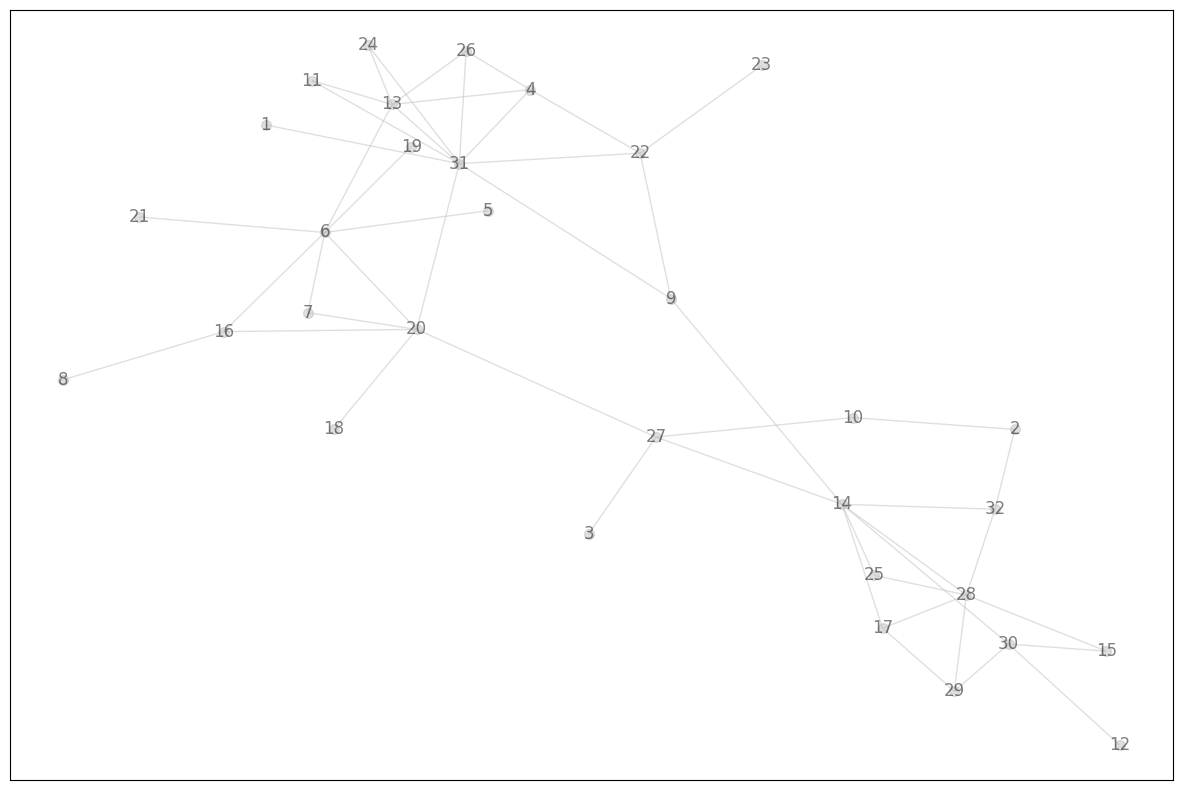

In [13]:
# Draw network
nx.draw_networkx(graph, pos=pos, node_size=50, node_color="silver", edge_color="silver", alpha=0.5, with_labels=True)
plt.show()

# Community Detection Algorithms

## Greedy Modularity communities

In [14]:
# Community Detection using greedy_modularity_communities Algorithm
start_time = datetime.now()
greedy_communities = sorted(nxcom.greedy_modularity_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [15]:
# Set node communities
set_node_community(graph, greedy_communities)

In [16]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [17]:
# Find maximum number of external edges connected to perticular community for node
greedy_external_edges = findExternalMax(node_edges_external)

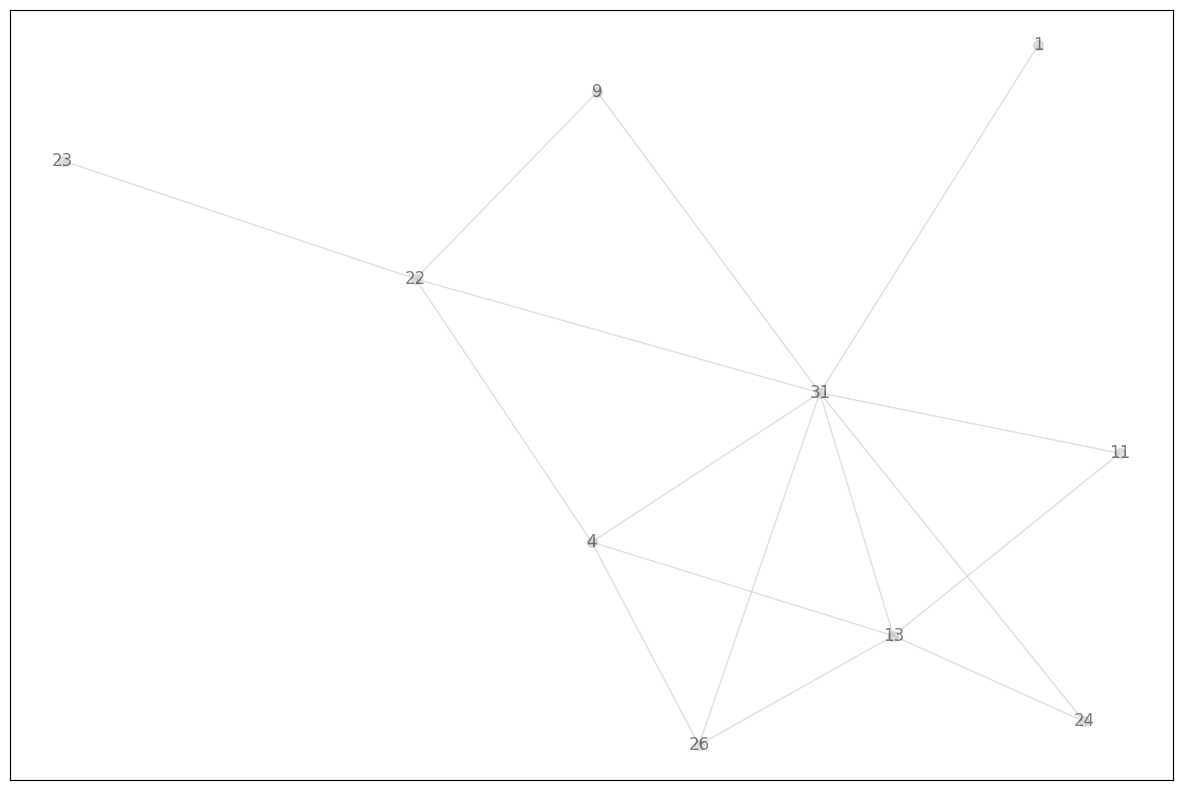

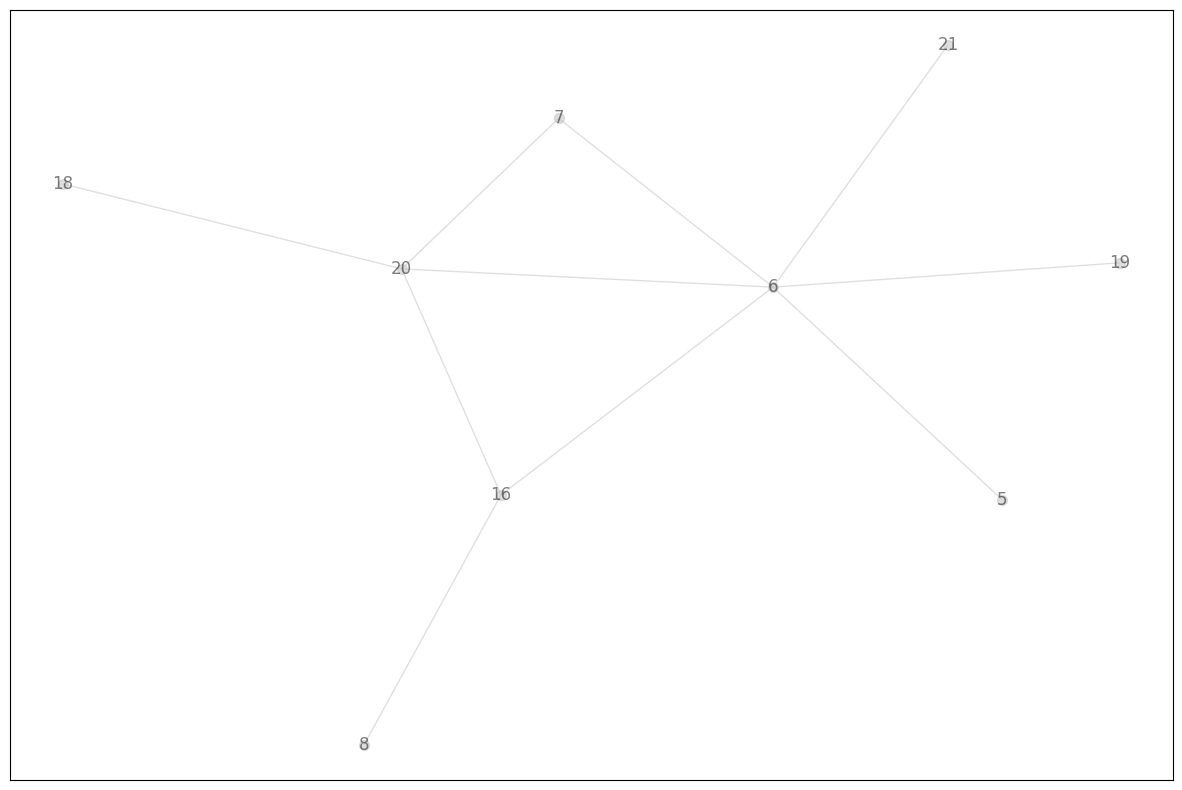

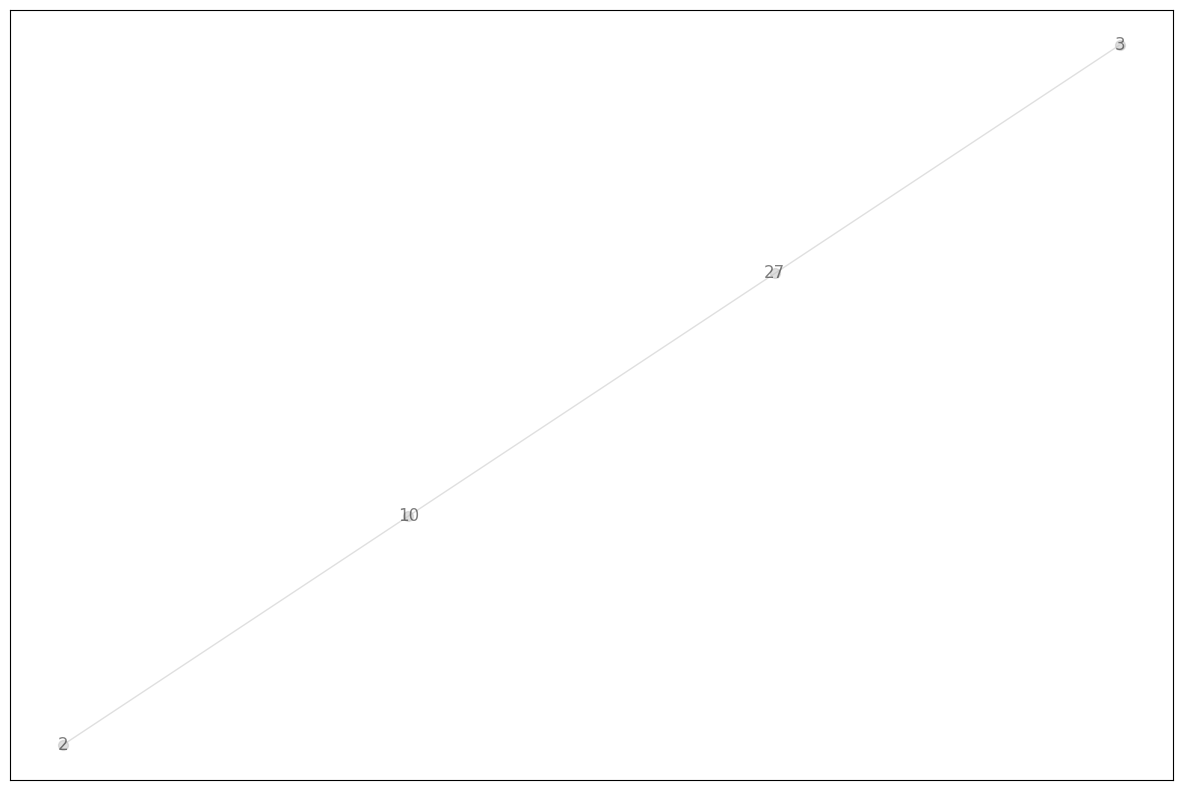

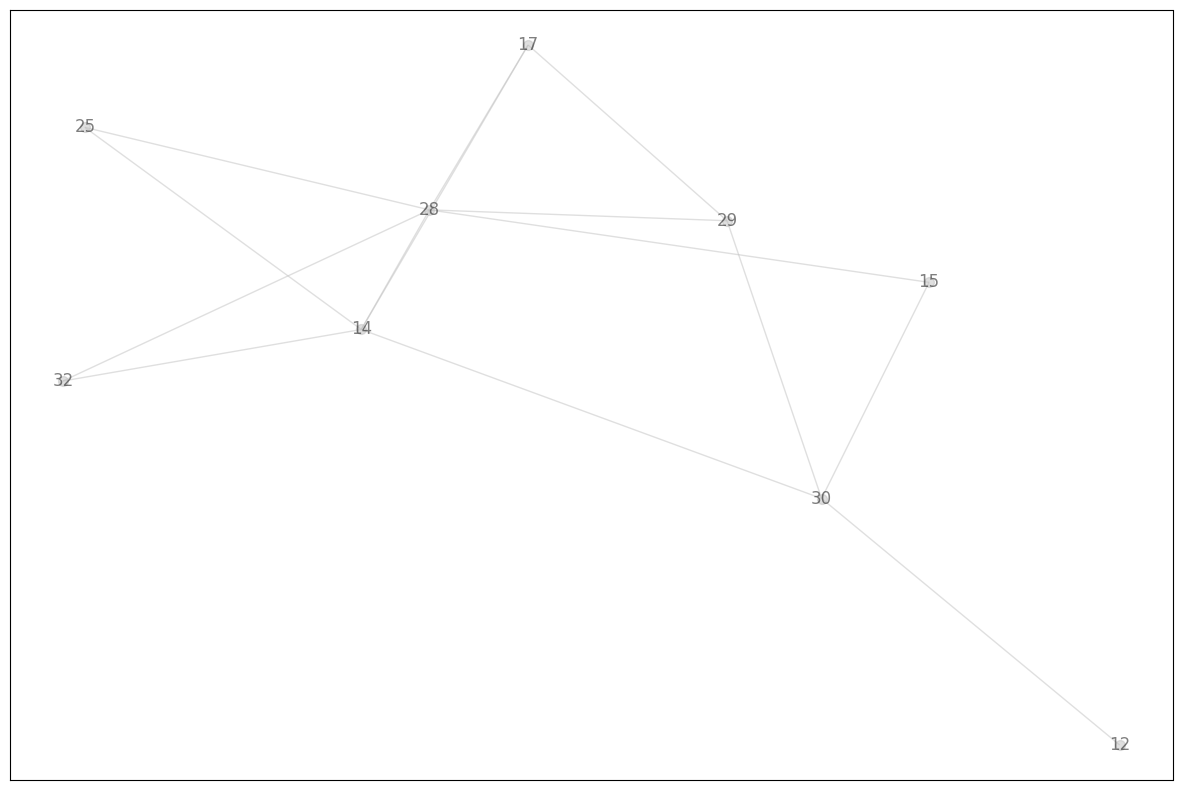

In [18]:
# Get Internal Clustering Coefficient for all nodes in Community 
greedy_coefficient = getCoefficient(inner_edges)

In [19]:
# Claculating Permanence value for each nodes
greedy_permanence = calculatePermanence(node_edges_internal, greedy_external_edges, degree_list, greedy_coefficient)

In [20]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [21]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [22]:
# Communities Descriptions
print(f"The network has {len(greedy_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(greedy_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t {d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.002208

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			 0.356 		 1.000
2 		9 		15 		 3			 0.417 		 1.000
3 		9 		10 		 3			 0.278 		 0.875
4 		4 		3 		 3			 0.500 		 1.333


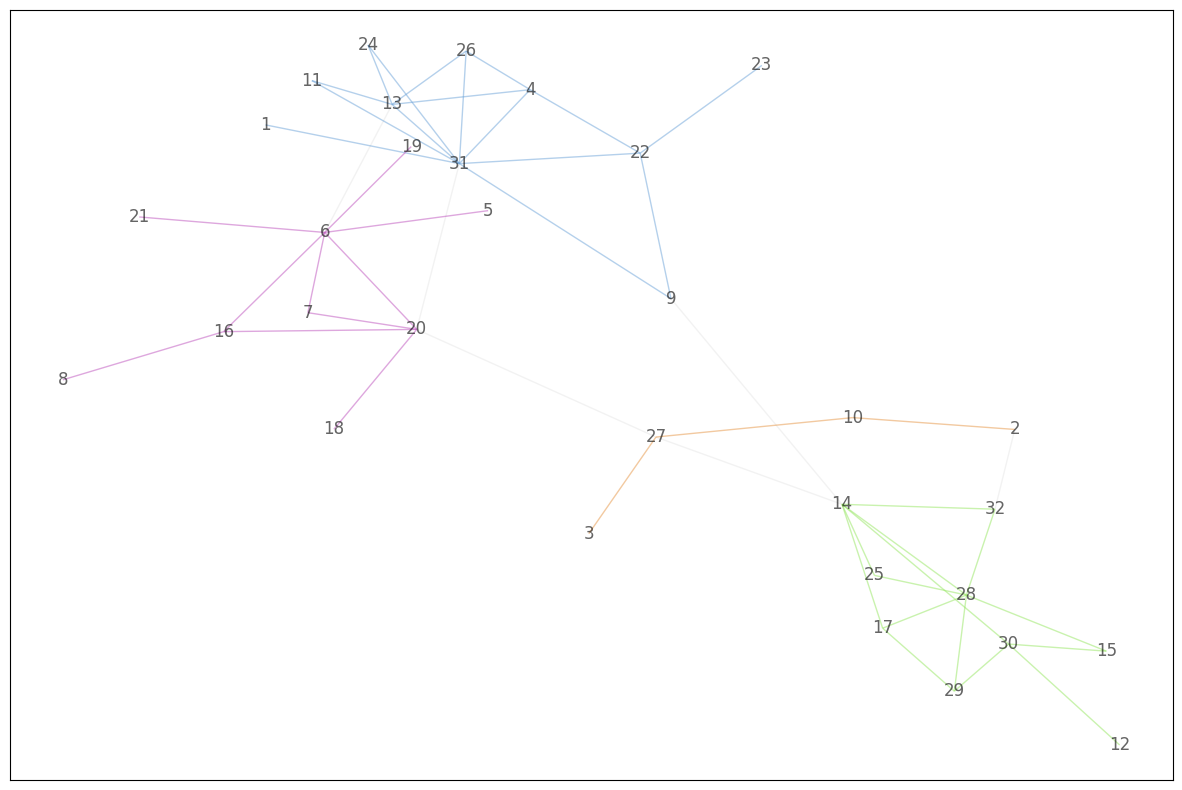

In [23]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=0, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [24]:
greedy_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 4: {'2': -0.5, '10': 0, '27': -0.5, '3': 0},
 2: {'32': 0.6666666666666666,
  '14': 0.014285714285714346,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

In [25]:
greedy_coefficient

{1: {'1': 0,
  '31': 0.25,
  '4': 0.6666666666666666,
  '9': 1.0,
  '13': 0.5,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': 0.13333333333333333,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': 0.3333333333333333,
  '8': 0,
  '18': 0},
 4: {'2': 0, '10': 0, '27': 0, '3': 0},
 2: {'32': 1.0,
  '14': 0.3,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

## Label Propagation Communities

In [26]:
# Community Detection using label_propagation_communities Algorithm
start_time = datetime.now()
label_communities = sorted(nxcom.label_propagation_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [27]:
# Set node communities
set_node_community(graph, label_communities)

In [28]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [29]:
# Find maximum number of external edges connected to perticular community for node
label_external_edges = findExternalMax(node_edges_external)

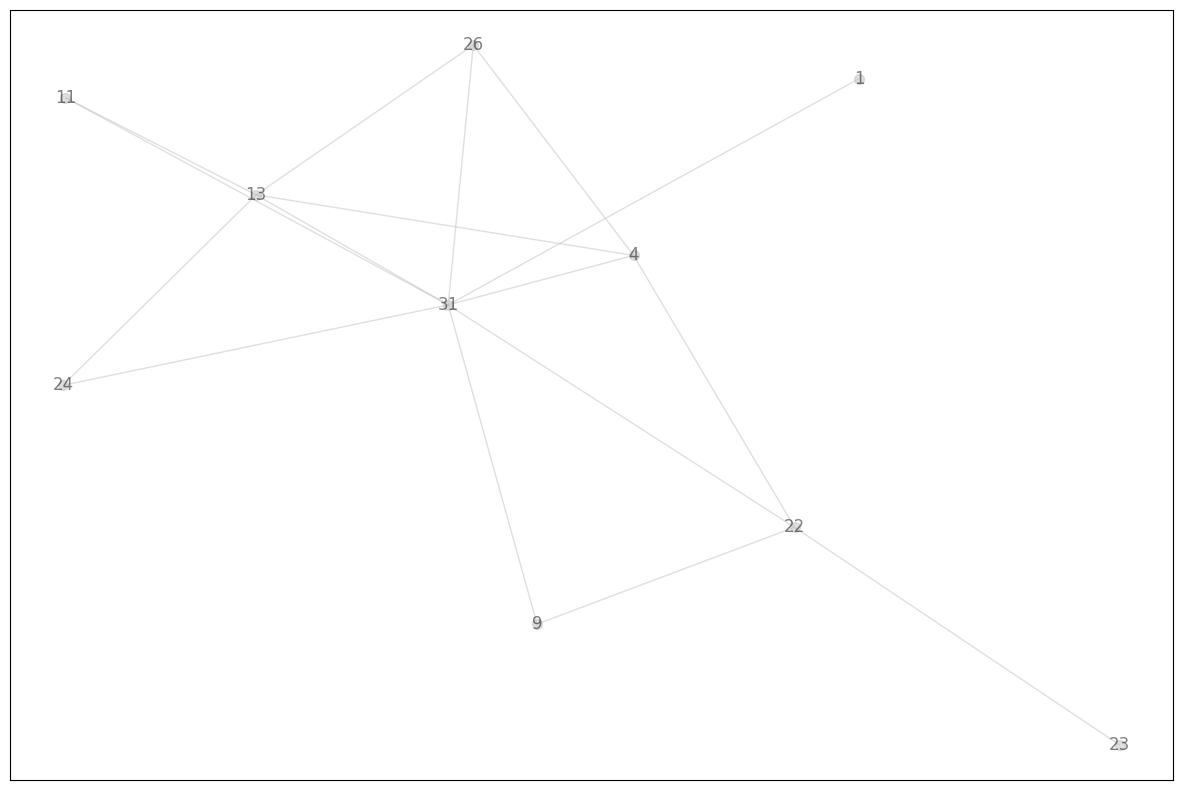

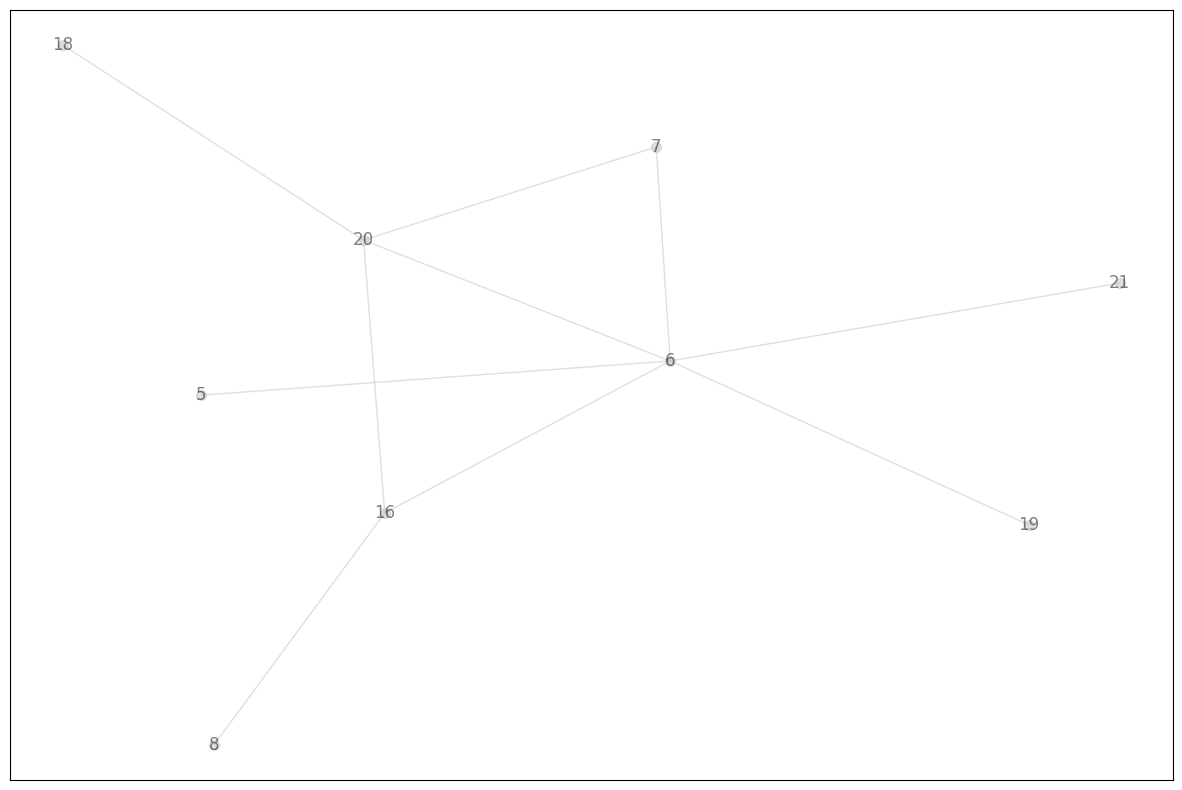

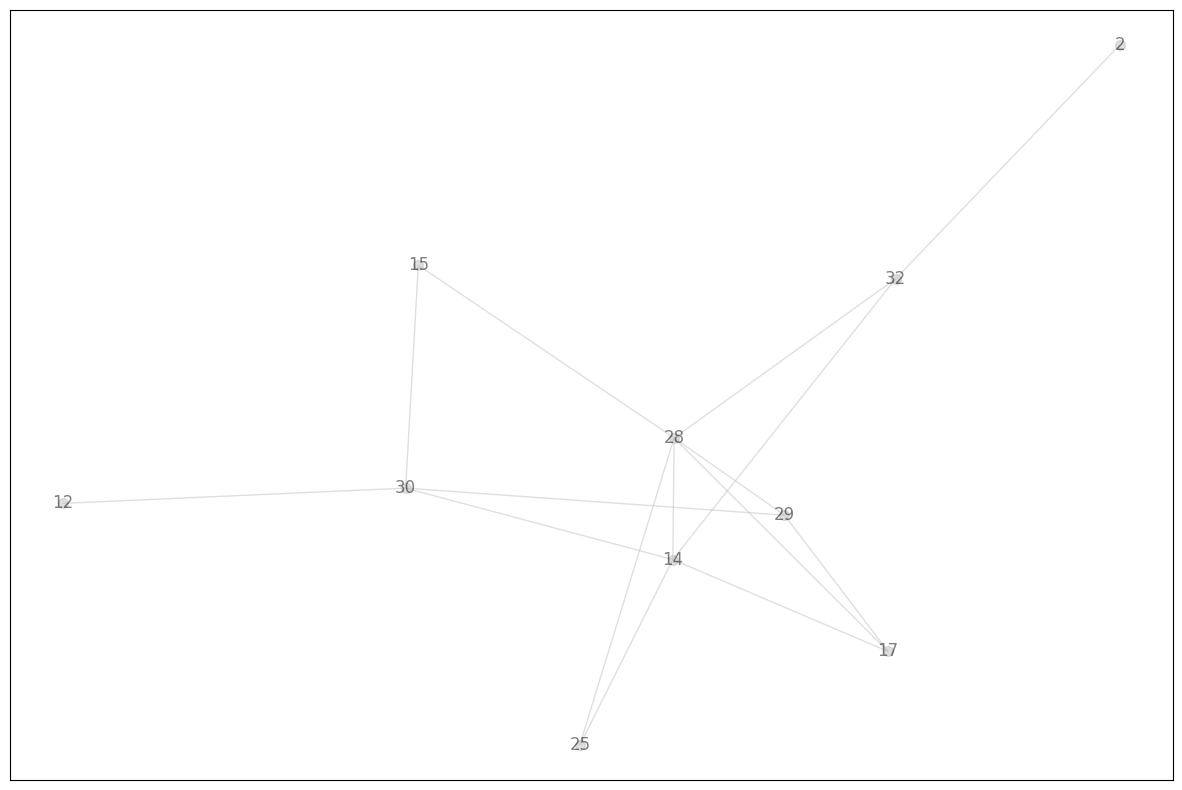

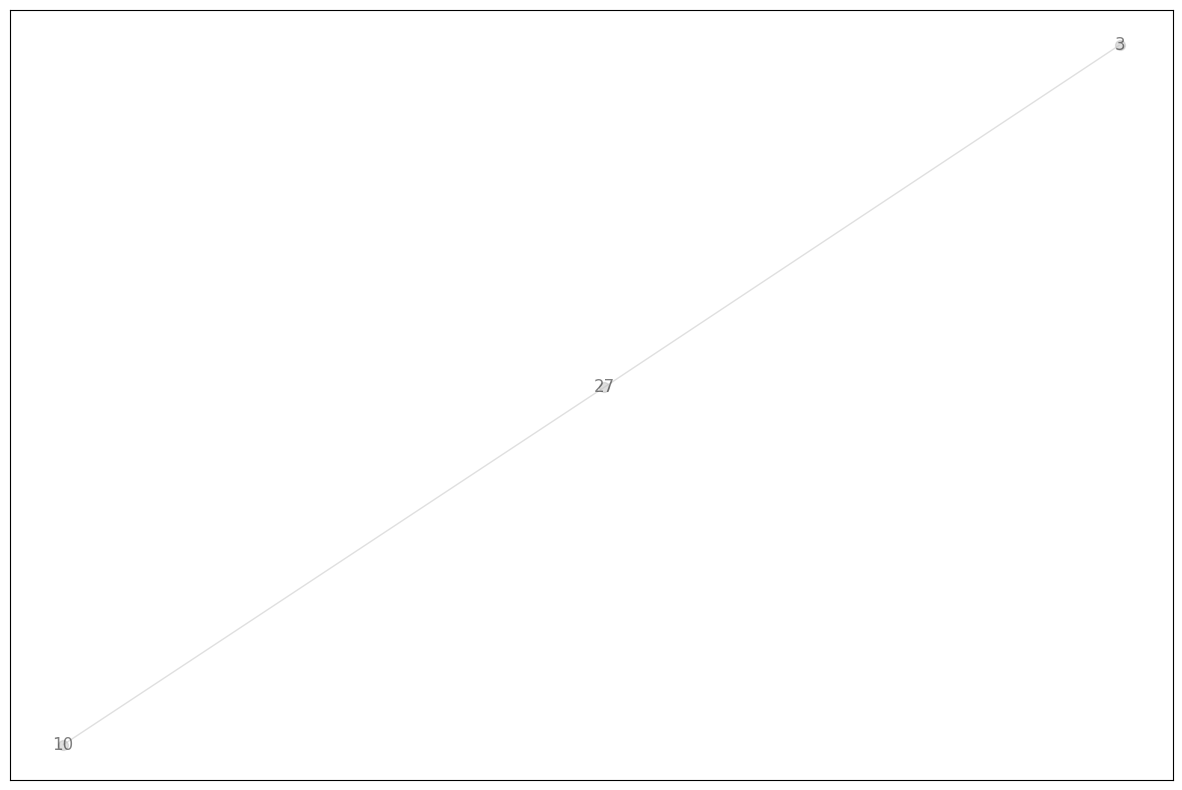

In [30]:
# Get Internal Clustering Coefficient for all nodes in Community 
label_coefficient = getCoefficient(inner_edges)

In [31]:
# Claculating Permanence value for each nodes
label_permanence = calculatePermanence(node_edges_internal, label_external_edges, degree_list, label_coefficient)

In [32]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [33]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [34]:
# Communities Descriptions
print(f"The network has {len(label_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(label_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 4 communities.

Time taken by algorithm 0:00:00.001235

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		10 		16 		 3			0.356 		 0.889
3 		9 		10 		 3			0.278 		 0.875
4 		3 		2 		 3			0.667 		 2.000


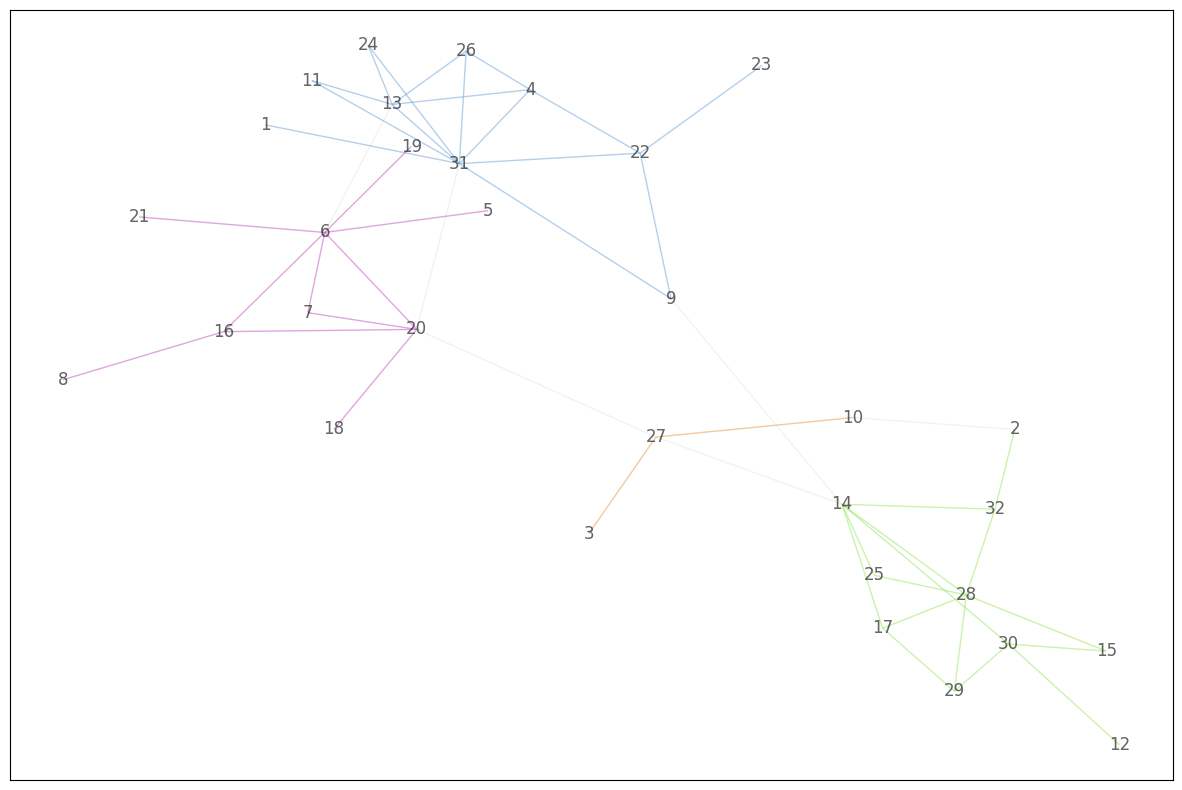

In [35]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=0, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [36]:
label_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 2: {'2': -0.5,
  '32': 0.3333333333333333,
  '14': 0.014285714285714346,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333},
 4: {'10': -0.5, '27': -0.5, '3': 0}}

In [37]:
label_external_edges

{1: {'nodes': {'1': (1, 0),
   '31': (3, 1),
   '4': (1, 0),
   '9': (2, 1),
   '13': (3, 1),
   '22': (1, 0),
   '24': (1, 0),
   '26': (1, 0),
   '11': (1, 0),
   '23': (1, 0)},
  'max_external_edge': 1,
  'node': '31',
  'external_community': 3},
 3: {'nodes': {'20': (1, 1),
   '6': (1, 1),
   '5': (3, 0),
   '16': (3, 0),
   '19': (3, 0),
   '21': (3, 0),
   '7': (3, 0),
   '8': (3, 0),
   '18': (3, 0)},
  'max_external_edge': 1,
  'node': '20',
  'external_community': 1},
 2: {'nodes': {'2': (4, 1),
   '32': (2, 0),
   '14': (4, 1),
   '28': (2, 0),
   '17': (2, 0),
   '25': (2, 0),
   '30': (2, 0),
   '12': (2, 0),
   '15': (2, 0),
   '29': (2, 0)},
  'max_external_edge': 1,
  'node': '2',
  'external_community': 4},
 4: {'nodes': {'10': (2, 1), '27': (2, 1), '3': (4, 0)},
  'max_external_edge': 1,
  'node': '10',
  'external_community': 2}}

## Girvan Newman

In [38]:
# Community Detection using girvan_newman Algorithm
start_time = datetime.now()
communities_generator = girvan_newman(graph)
next(communities_generator)
girvan_communities = next(communities_generator)
end_time = datetime.now()

In [39]:
# Set node communities
set_node_community(graph, girvan_communities)

In [40]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [41]:
# Find maximum number of external edges connected to perticular community for node
girvan_external_edges = findExternalMax(node_edges_external)

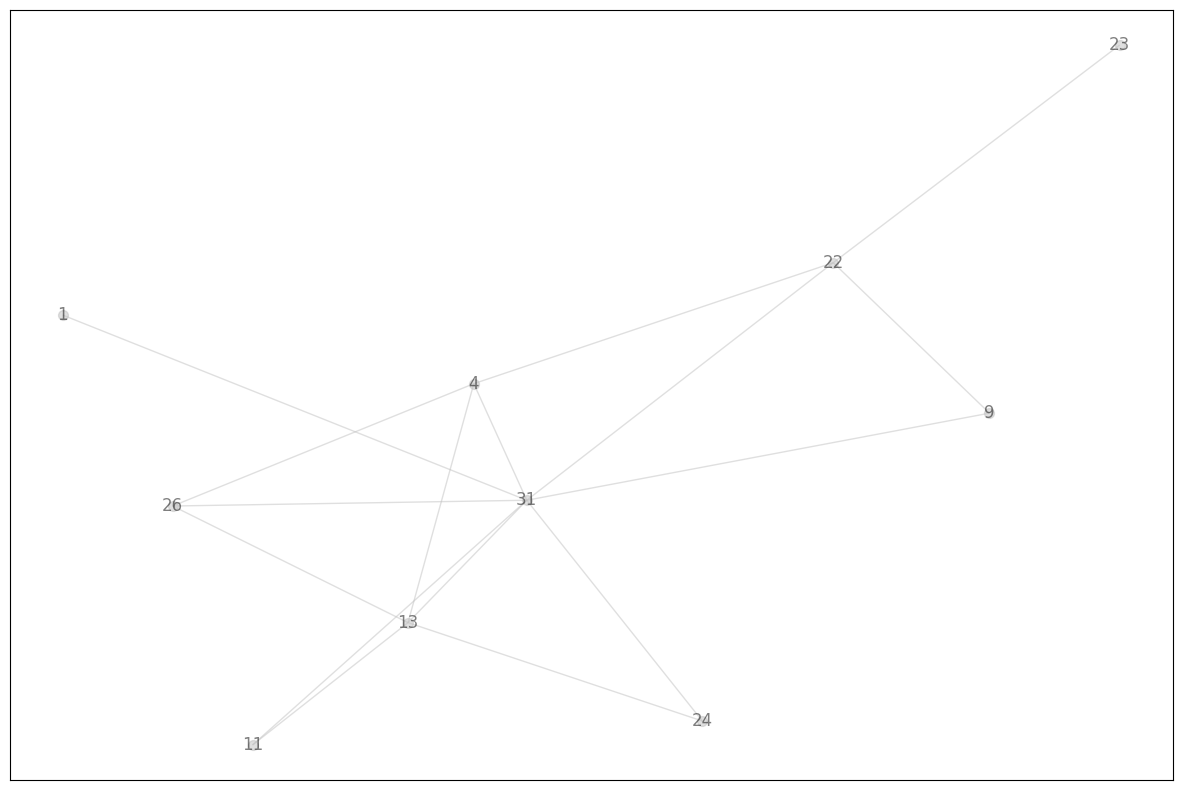

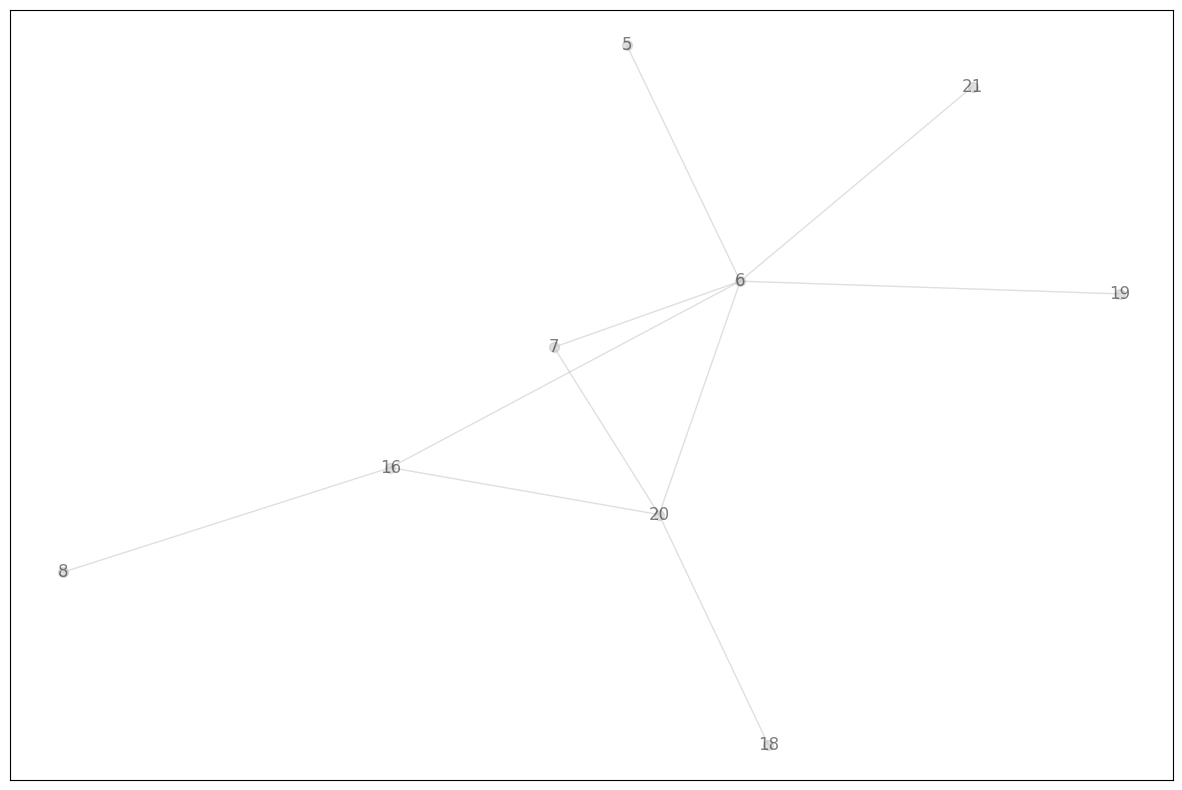

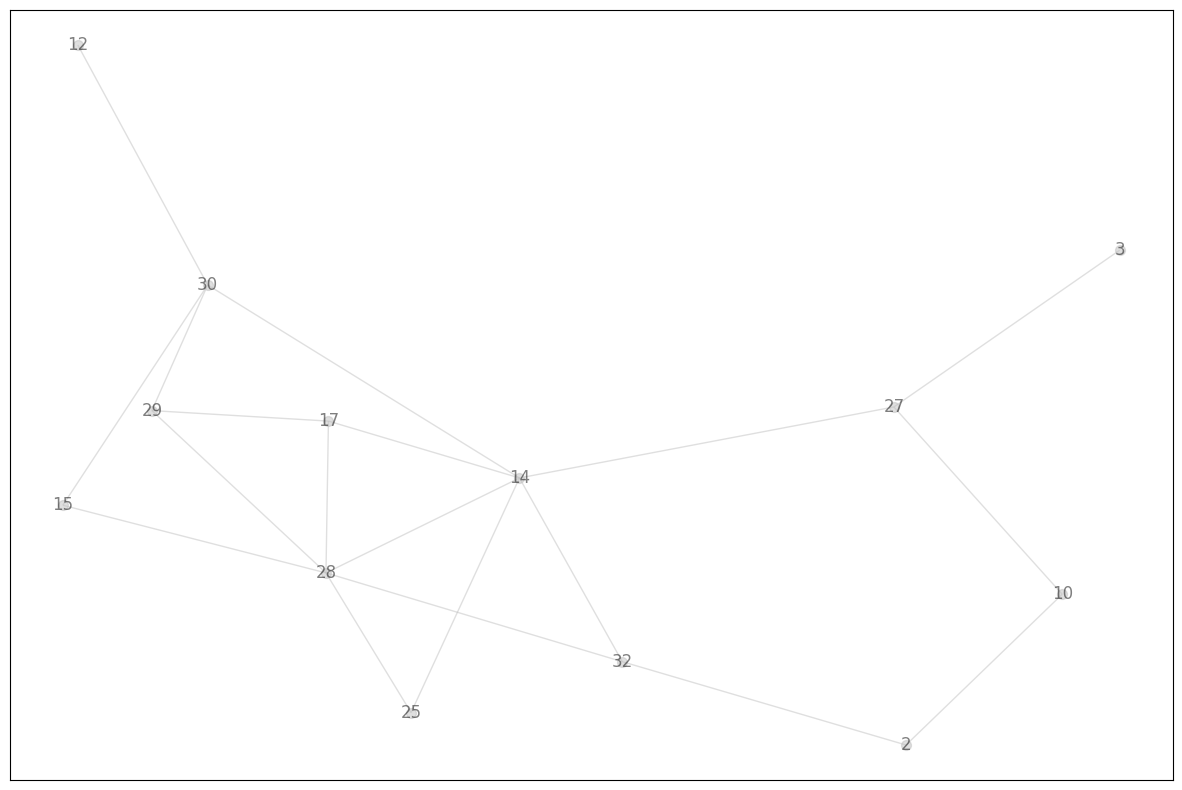

In [42]:
# Get Internal Clustering Coefficient for all nodes in Community 
girvan_coefficient = getCoefficient(inner_edges)

In [43]:
# Claculating Permanence value for each nodes
girvan_permanence = calculatePermanence(node_edges_internal, girvan_external_edges, degree_list, girvan_coefficient)

In [44]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [45]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [46]:
# Communities Descriptions
print(f"The network has {len(girvan_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(girvan_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Time taken by algorithm 0:00:00.011803

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		10 		16 		 3			0.356 		 1.000
2 		13 		20 		 2			0.256 		 0.667
3 		9 		10 		 3			0.278 		 0.875


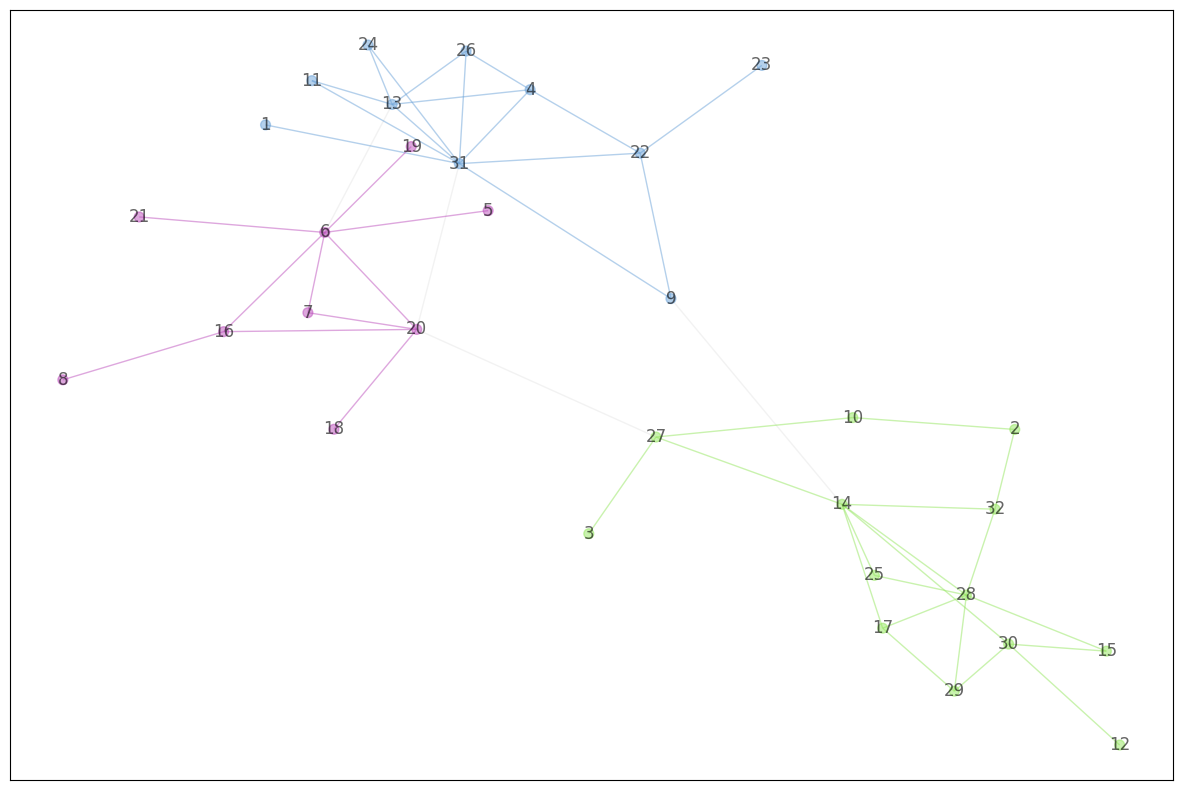

In [47]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [48]:
girvan_permanence

{1: {'1': 0,
  '31': 0.13888888888888884,
  '4': 0.6666666666666666,
  '9': 0.6666666666666666,
  '13': 0.33333333333333337,
  '22': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '23': 0},
 3: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 2: {'2': 0,
  '10': 0,
  '32': 0.3333333333333333,
  '27': -0.25,
  '14': 0.05714285714285705,
  '28': 0.26666666666666666,
  '3': 0,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

In [49]:
girvan_external_edges

{1: {'nodes': {'1': (1, 0),
   '31': (3, 1),
   '4': (1, 0),
   '9': (2, 1),
   '13': (3, 1),
   '22': (1, 0),
   '24': (1, 0),
   '26': (1, 0),
   '11': (1, 0),
   '23': (1, 0)},
  'max_external_edge': 1,
  'node': '31',
  'external_community': 3},
 3: {'nodes': {'20': (1, 1),
   '6': (1, 1),
   '5': (3, 0),
   '16': (3, 0),
   '19': (3, 0),
   '21': (3, 0),
   '7': (3, 0),
   '8': (3, 0),
   '18': (3, 0)},
  'max_external_edge': 1,
  'node': '20',
  'external_community': 1},
 2: {'nodes': {'2': (2, 0),
   '10': (2, 0),
   '32': (2, 0),
   '27': (3, 1),
   '14': (1, 1),
   '28': (2, 0),
   '3': (2, 0),
   '17': (2, 0),
   '25': (2, 0),
   '30': (2, 0),
   '12': (2, 0),
   '15': (2, 0),
   '29': (2, 0)},
  'max_external_edge': 1,
  'node': '27',
  'external_community': 3}}

## Asyn Lpa Communities

In [50]:
# Community Detection using asyn_lpa_communities Algorithm
start_time = datetime.now()
lpa_communities = sorted(nxcom.asyn_lpa_communities(graph), key=len, reverse=True)
end_time = datetime.now()

In [51]:
# Set node communities
set_node_community(graph, lpa_communities)

In [52]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [53]:
# Find maximum number of external edges connected to perticular community for node
lpa_external_edges = findExternalMax(node_edges_external)

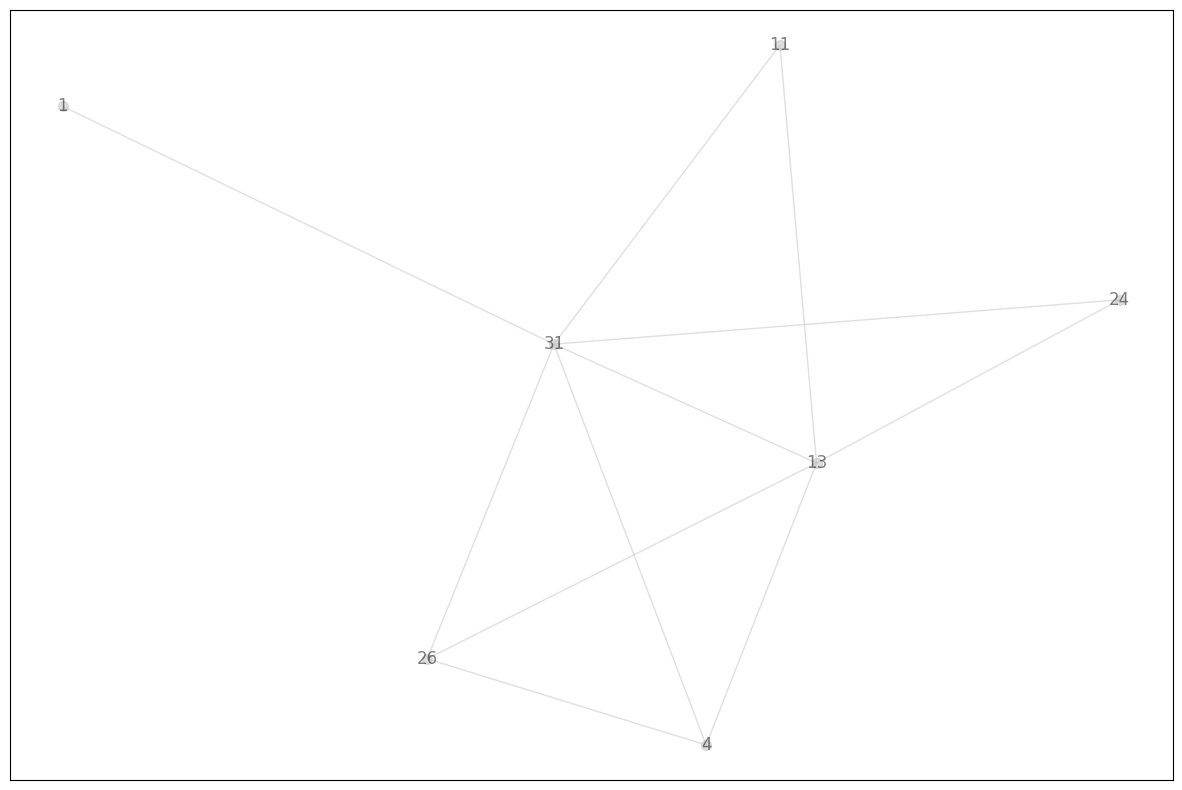

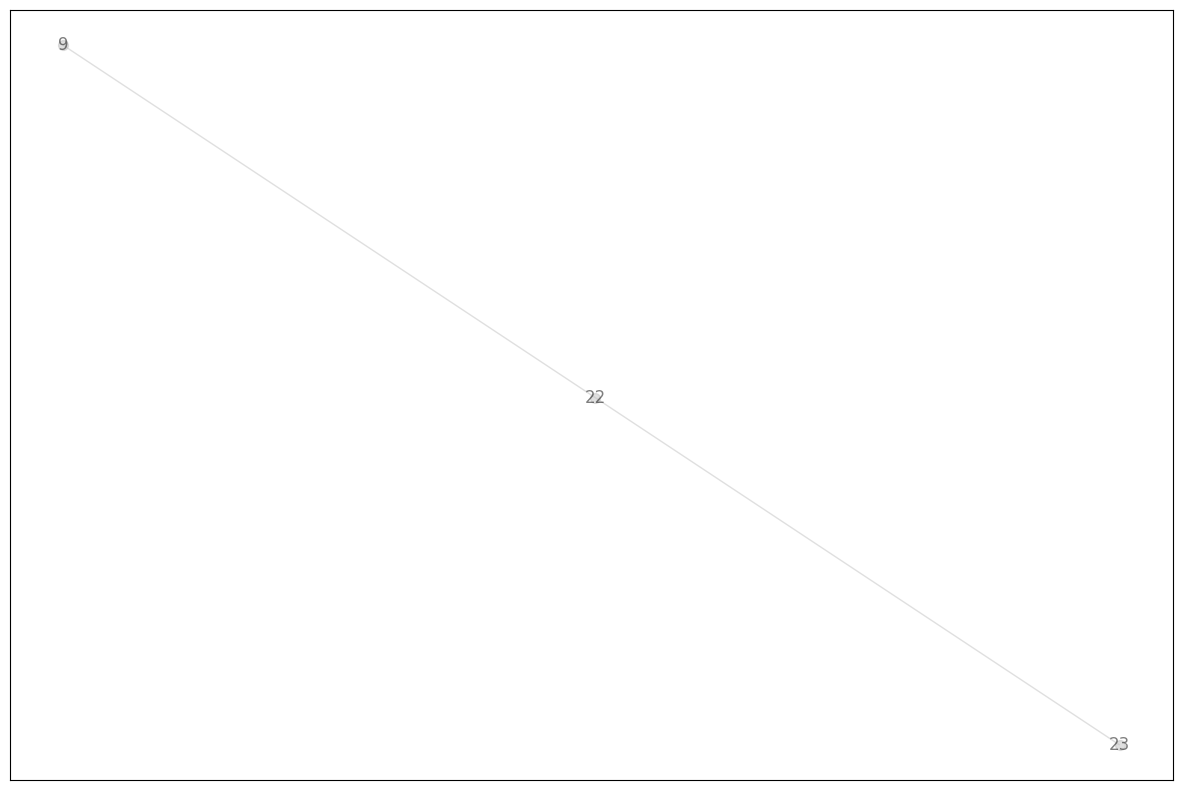

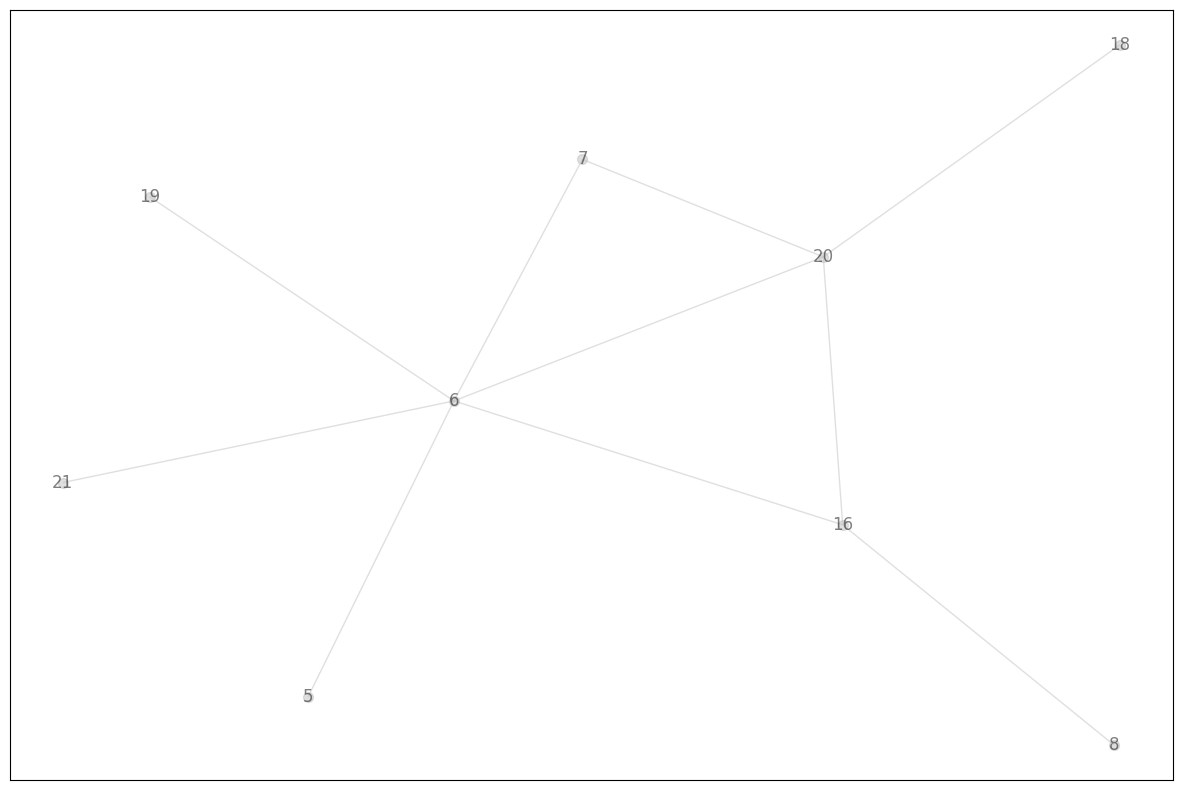

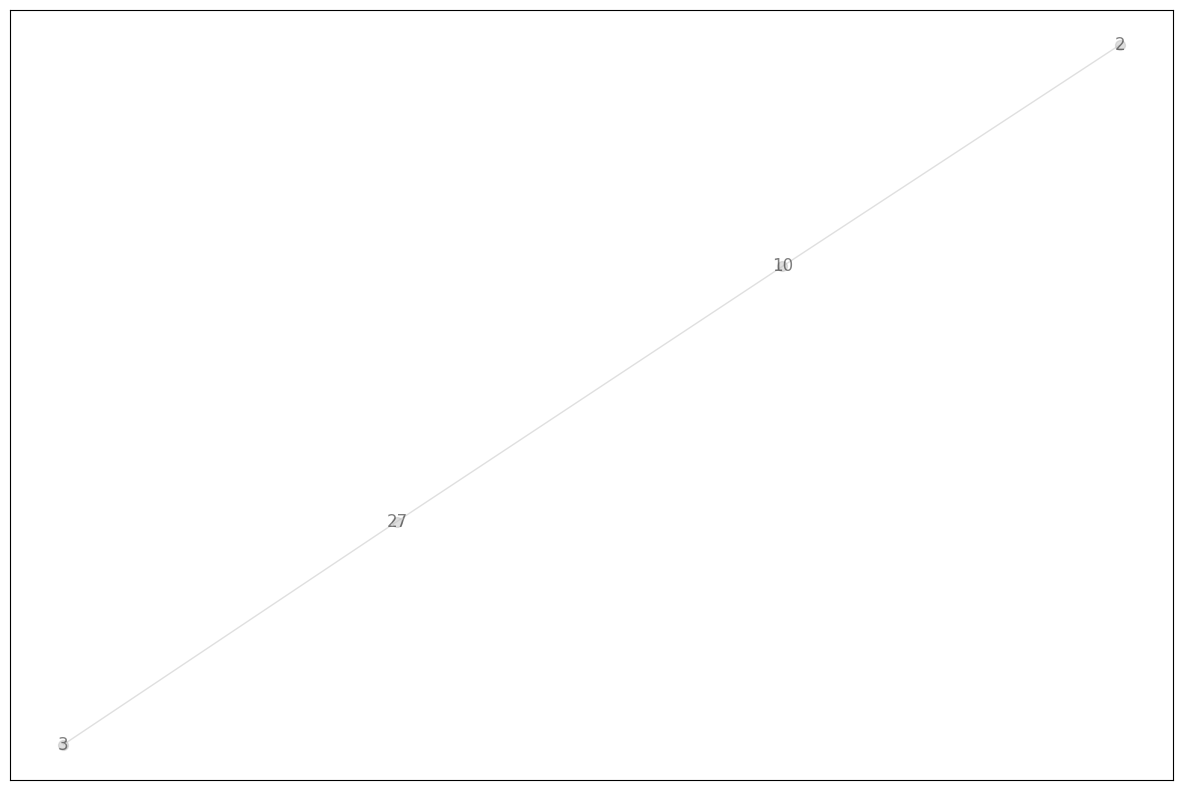

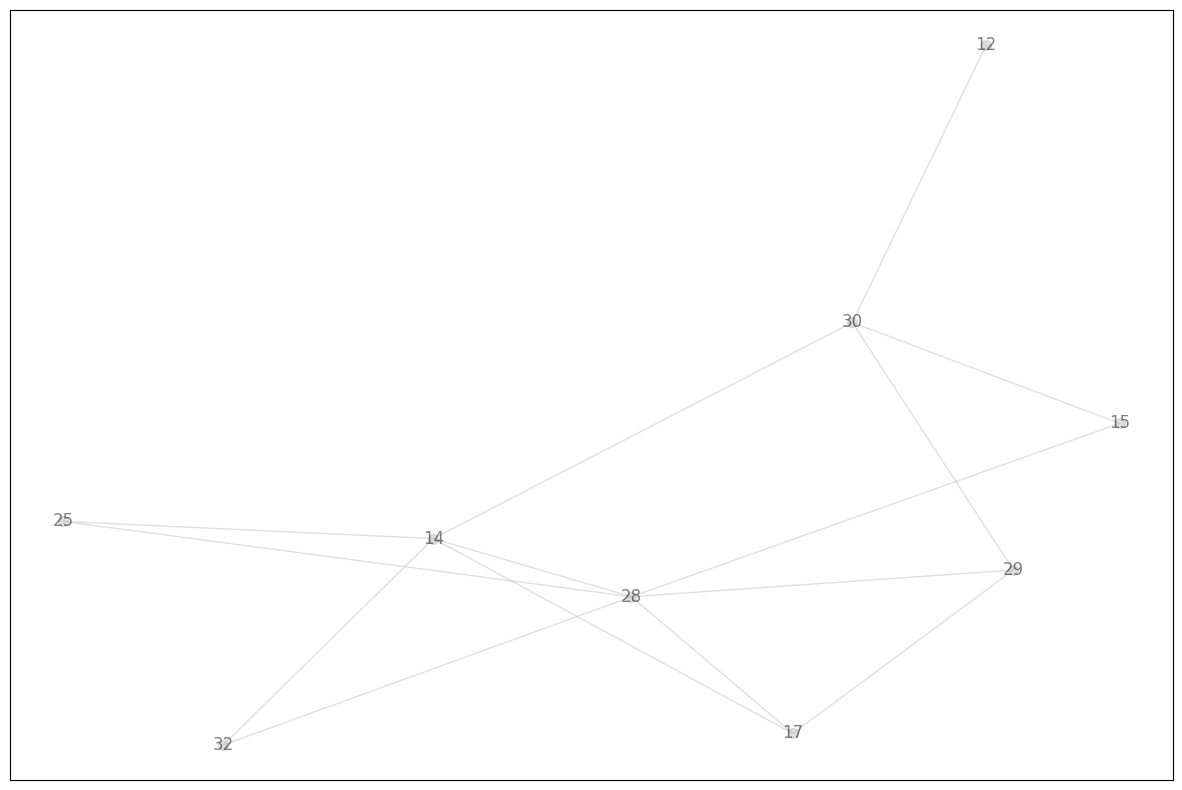

In [54]:
# Get Internal Clustering Coefficient for all nodes in Community 
lpa_coefficient = getCoefficient(inner_edges)

In [55]:
# Claculating Permanence value for each nodes
lpa_permanence = calculatePermanence(node_edges_internal, lpa_external_edges, degree_list, lpa_coefficient)

In [56]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [57]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [58]:
# Communities Descriptions
print(f"The network has {len(lpa_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(lpa_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 5 communities.

Time taken by algorithm 0:00:00.001269

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		9 		15 		 3			0.417 		 1.000
2 		9 		10 		 3			0.278 		 0.875
3 		7 		11 		 5			0.524 		 1.500
4 		4 		3 		 3			0.500 		 1.333
5 		3 		2 		 4			0.667 		 2.000


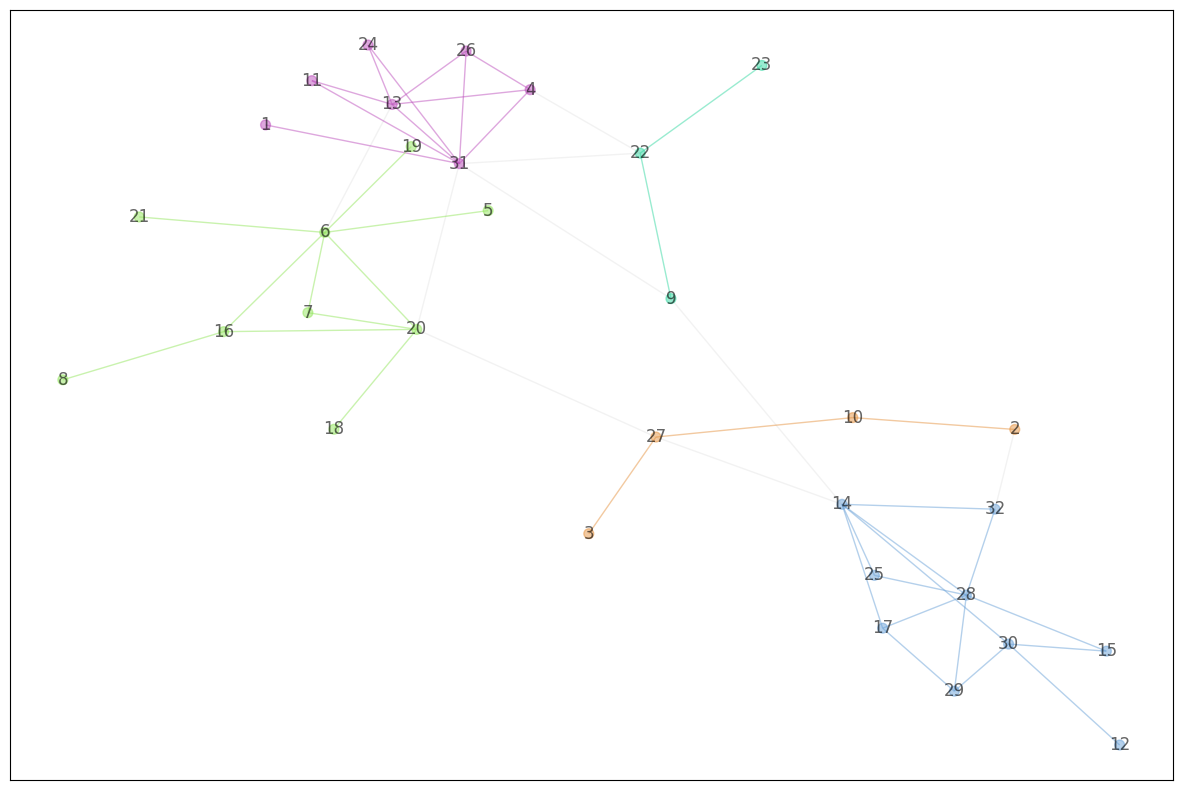

In [59]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [60]:
lpa_permanence

{3: {'1': 0,
  '31': -0.3333333333333334,
  '4': 0.75,
  '13': 0.33333333333333337,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0},
 5: {'22': -0.75, '9': -0.6666666666666667, '23': 0},
 2: {'6': -0.009523809523809601,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '20': -1.1102230246251565e-16,
  '8': 0,
  '18': 0},
 4: {'2': -0.5, '10': 0, '27': -0.5, '3': 0},
 1: {'32': 0.6666666666666666,
  '14': 0.014285714285714346,
  '28': 0.26666666666666666,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

In [61]:
lpa_external_edges

{3: {'nodes': {'1': (3, 0),
   '31': (5, 2),
   '4': (5, 1),
   '13': (2, 1),
   '24': (3, 0),
   '26': (3, 0),
   '11': (3, 0)},
  'max_external_edge': 2,
  'node': '31',
  'external_community': 5},
 5: {'nodes': {'9': (3, 1), '22': (3, 2), '23': (5, 0)},
  'max_external_edge': 2,
  'node': '22',
  'external_community': 3},
 2: {'nodes': {'20': (3, 1),
   '6': (3, 1),
   '5': (2, 0),
   '16': (2, 0),
   '19': (2, 0),
   '21': (2, 0),
   '7': (2, 0),
   '8': (2, 0),
   '18': (2, 0)},
  'max_external_edge': 1,
  'node': '20',
  'external_community': 3},
 4: {'nodes': {'2': (1, 1), '10': (4, 0), '27': (1, 1), '3': (4, 0)},
  'max_external_edge': 1,
  'node': '2',
  'external_community': 1},
 1: {'nodes': {'32': (4, 1),
   '14': (4, 1),
   '28': (1, 0),
   '17': (1, 0),
   '25': (1, 0),
   '30': (1, 0),
   '12': (1, 0),
   '15': (1, 0),
   '29': (1, 0)},
  'max_external_edge': 1,
  'node': '32',
  'external_community': 4}}

## Bisection

In [62]:
# Community Detection using kernighan_lin_bisection Algorithm
start_time = datetime.now()
bisection_communities = sorted(nxcom.kernighan_lin_bisection(graph), key=len, reverse=True)
end_time = datetime.now()

In [63]:
# Set node communities
set_node_community(graph, bisection_communities)

In [64]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [65]:
# Find maximum number of external edges connected to perticular community for node
bisection_external_edges = findExternalMax(node_edges_external)

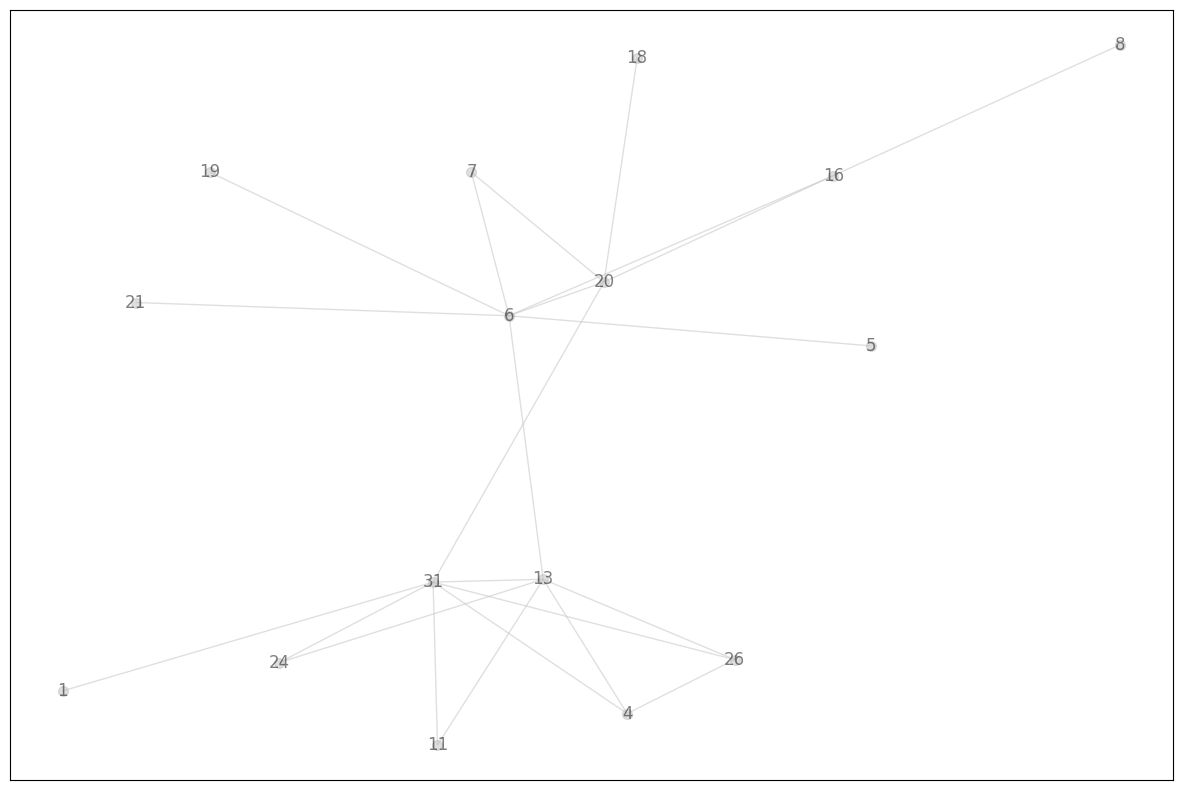

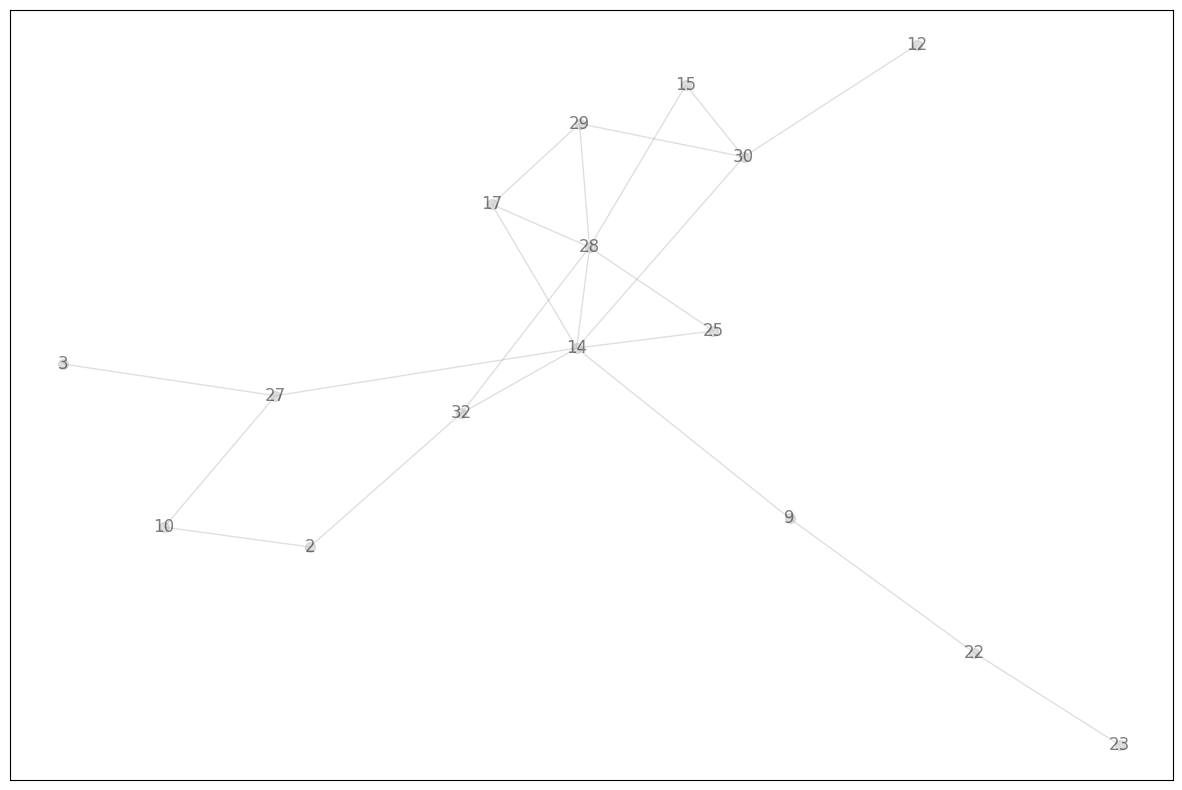

In [66]:
# Get Internal Clustering Coefficient for all nodes in Community 
bisection_coefficient = getCoefficient(inner_edges)

In [67]:
# Claculating Permanence value for each nodes
bisection_permanence = calculatePermanence(node_edges_internal, bisection_external_edges, degree_list, bisection_coefficient)

In [68]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [69]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [70]:
# Communities Descriptions
print(f"The network has {len(bisection_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(bisection_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 2 communities.

Time taken by algorithm 0:00:00.006265

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		16 		23 		 4			0.192 		 0.533
2 		16 		23 		 4			0.192 		 0.600


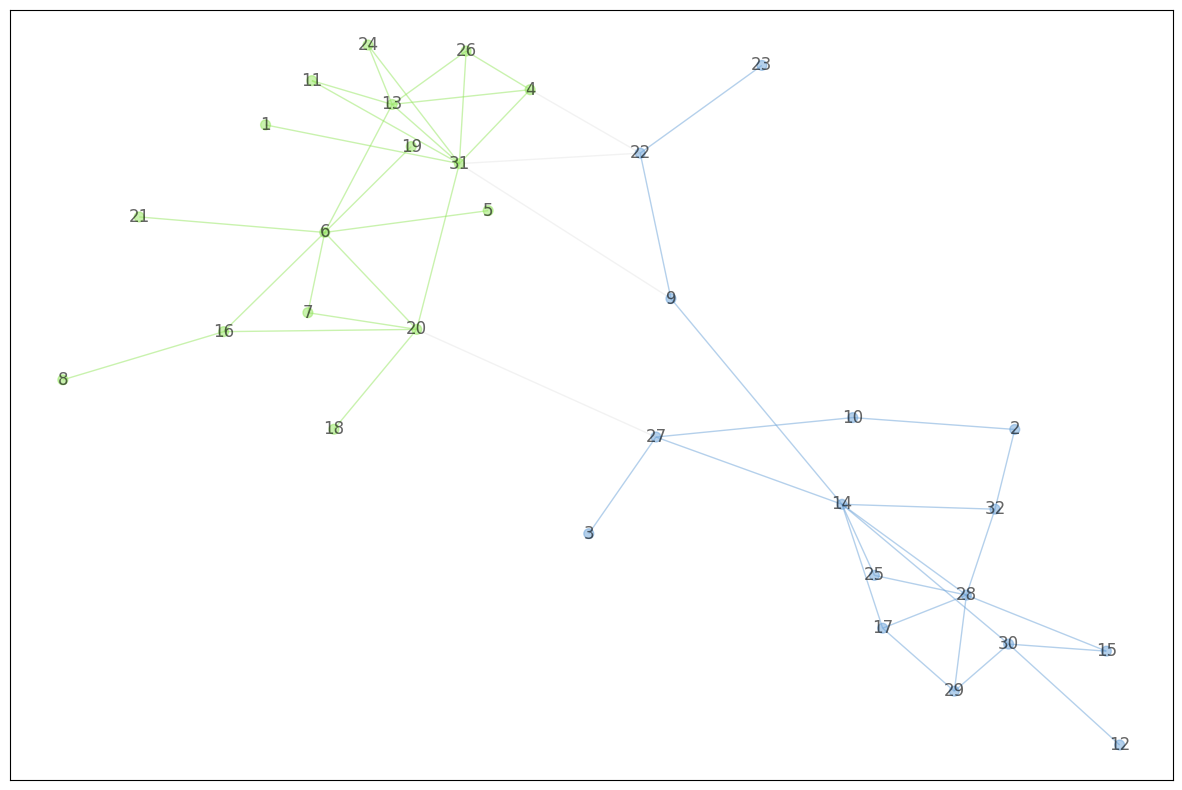

In [71]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [72]:
bisection_permanence

{2: {'1': 0,
  '31': -0.37301587301587297,
  '4': 0.75,
  '13': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '20': 0.033333333333333326,
  '6': 0.09523809523809523,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '8': 0,
  '18': 0},
 1: {'2': 0,
  '10': 0,
  '32': 0.3333333333333333,
  '27': -0.25,
  '14': 0.14285714285714285,
  '28': 0.26666666666666666,
  '3': 0,
  '22': -0.75,
  '9': -0.33333333333333337,
  '23': 0,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

In [73]:
bisection_external_edges

{2: {'nodes': {'1': (2, 0),
   '31': (1, 2),
   '4': (1, 1),
   '13': (2, 0),
   '24': (2, 0),
   '26': (2, 0),
   '11': (2, 0),
   '20': (1, 1),
   '6': (2, 0),
   '5': (2, 0),
   '16': (2, 0),
   '19': (2, 0),
   '21': (2, 0),
   '7': (2, 0),
   '8': (2, 0),
   '18': (2, 0)},
  'max_external_edge': 2,
  'node': '31',
  'external_community': 1},
 1: {'nodes': {'9': (2, 1),
   '22': (2, 2),
   '2': (1, 0),
   '10': (1, 0),
   '32': (1, 0),
   '27': (2, 1),
   '14': (1, 0),
   '28': (1, 0),
   '3': (1, 0),
   '23': (1, 0),
   '17': (1, 0),
   '25': (1, 0),
   '30': (1, 0),
   '12': (1, 0),
   '15': (1, 0),
   '29': (1, 0)},
  'max_external_edge': 2,
  'node': '22',
  'external_community': 2}}

## k Clique Communities

In [74]:
# Community Detection using k_clique_communities Algorithm
start_time = datetime.now()
clique_communities = list(k_clique_communities(graph, 10))
end_time = datetime.now()

In [75]:
# Set node communities
set_node_community(graph, clique_communities)

In [76]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [77]:
# Find maximum number of external edges connected to perticular community for node
clique_external_edges = findExternalMax(node_edges_external)

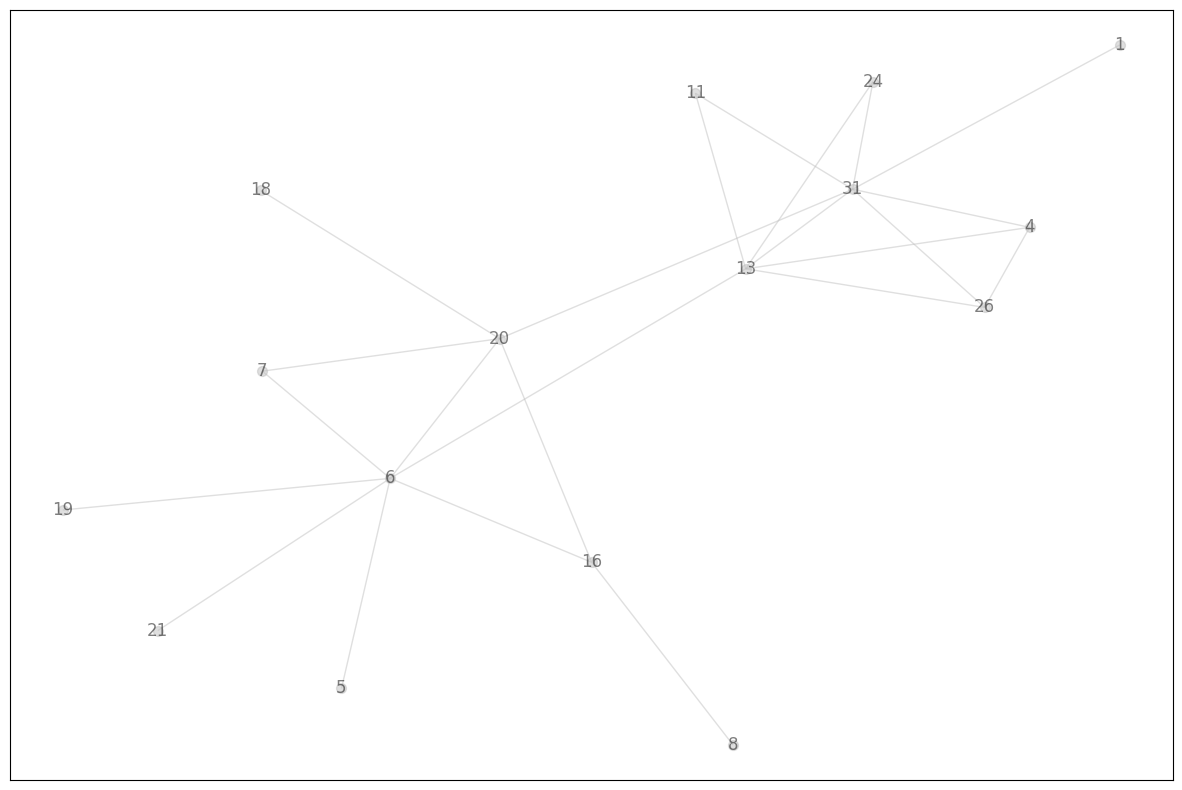

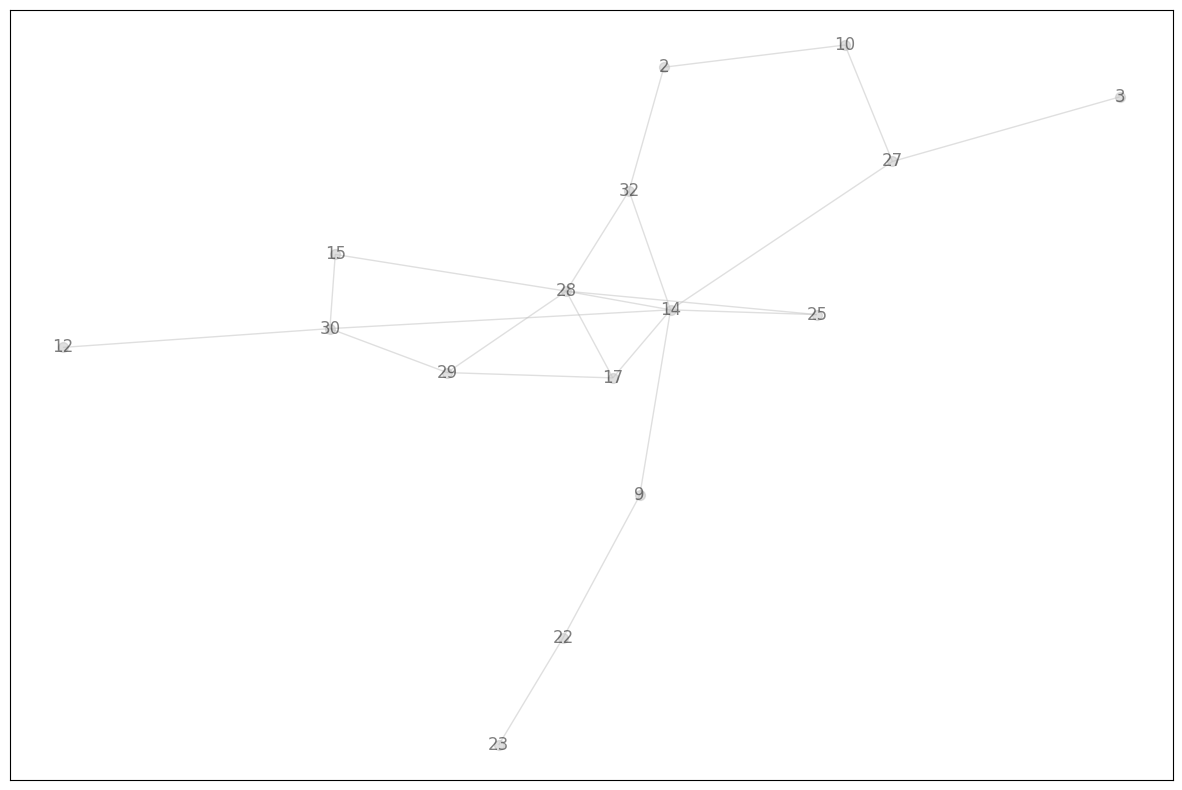

In [78]:
# Get Internal Clustering Coefficient for all nodes in Community 
clique_coefficient = getCoefficient(inner_edges)

In [79]:
# Claculating Permanence value for each nodes
clique_permanence = calculatePermanence(node_edges_internal, clique_external_edges, degree_list, clique_coefficient)

In [80]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [81]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [82]:
# Communities Descriptions
print(f"The network has {len(clique_communities)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(clique_communities):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 0 communities.

Time taken by algorithm 0:00:00.000256

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance


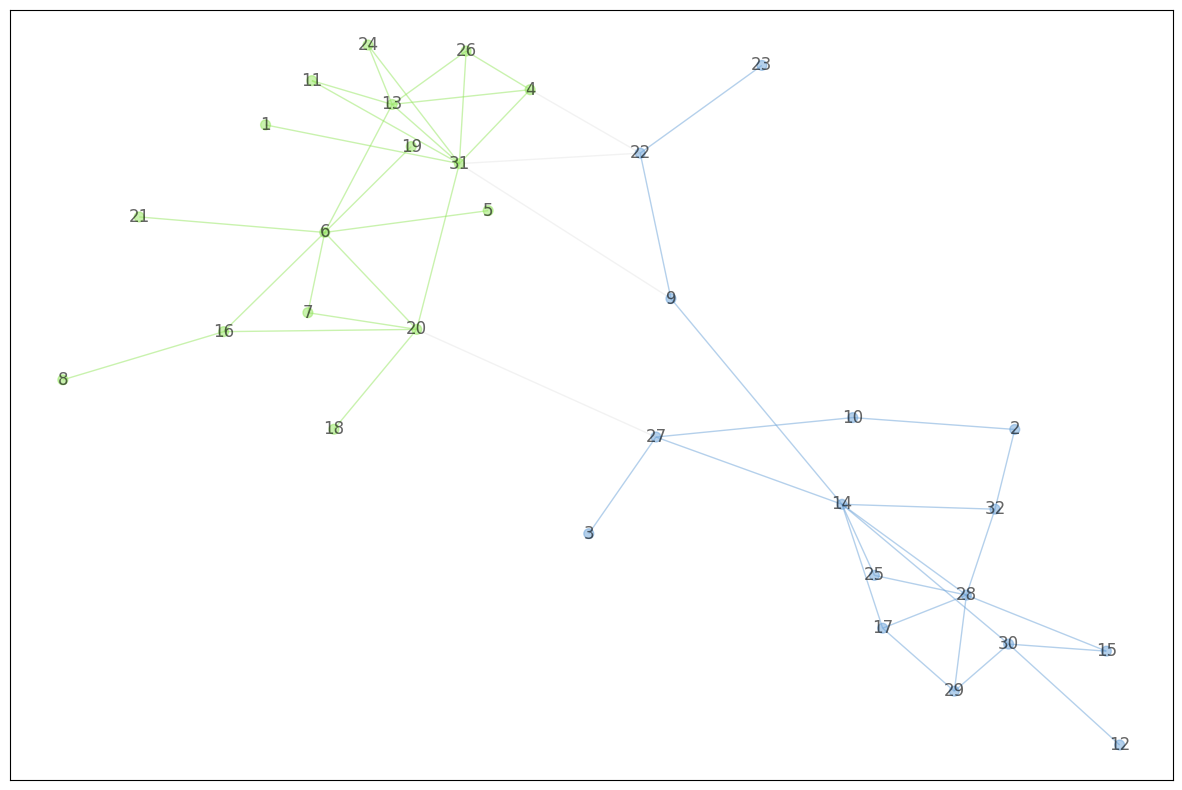

In [83]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()

In [84]:
clique_permanence

{2: {'1': 0,
  '31': -0.37301587301587297,
  '4': 0.75,
  '13': 0.3333333333333333,
  '24': 1.0,
  '26': 1.0,
  '11': 1.0,
  '20': 0.033333333333333326,
  '6': 0.09523809523809523,
  '5': 0,
  '16': 0.3333333333333333,
  '19': 0,
  '21': 0,
  '7': 1.0,
  '8': 0,
  '18': 0},
 1: {'2': 0,
  '10': 0,
  '32': 0.3333333333333333,
  '27': -0.25,
  '14': 0.14285714285714285,
  '28': 0.26666666666666666,
  '3': 0,
  '22': -0.75,
  '9': -0.33333333333333337,
  '23': 0,
  '17': 0.6666666666666666,
  '25': 1.0,
  '30': 0,
  '12': 0,
  '15': 0,
  '29': 0.3333333333333333}}

In [85]:
clique_external_edges

{2: {'nodes': {'1': (2, 0),
   '31': (1, 2),
   '4': (1, 1),
   '13': (2, 0),
   '24': (2, 0),
   '26': (2, 0),
   '11': (2, 0),
   '20': (1, 1),
   '6': (2, 0),
   '5': (2, 0),
   '16': (2, 0),
   '19': (2, 0),
   '21': (2, 0),
   '7': (2, 0),
   '8': (2, 0),
   '18': (2, 0)},
  'max_external_edge': 2,
  'node': '31',
  'external_community': 1},
 1: {'nodes': {'9': (2, 1),
   '22': (2, 2),
   '2': (1, 0),
   '10': (1, 0),
   '32': (1, 0),
   '27': (2, 1),
   '14': (1, 0),
   '28': (1, 0),
   '3': (1, 0),
   '23': (1, 0),
   '17': (1, 0),
   '25': (1, 0),
   '30': (1, 0),
   '12': (1, 0),
   '15': (1, 0),
   '29': (1, 0)},
  'max_external_edge': 2,
  'node': '22',
  'external_community': 2}}

## Constant community

In [86]:
def constant_communuty(*communities):
    if len(communities)>1:
        community = communities[0]
        for k in communities[1:]:
            ls = []
            for i in community:
                for j in k:
                    a = i.intersection(j)
                    if len(a)>3:
                        ls.append(a)
            community = ls
        return community
    else:
        return communities

In [87]:

ls1 = constant_communuty(greedy_communities, label_communities, girvan_communities, lpa_communities, bisection_communities)

In [88]:
# Create directed graph instance from dataset
graph = nx.parse_edgelist(edge_data, nodetype = str)

In [89]:
# Set node communities
set_node_community(graph, ls1)

In [90]:
# Set edge communities
edge_list, degree_list, node_edges_internal, node_edges_external, inner_edges = set_edge_community(graph)

In [91]:
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]

In [92]:
# Generate color for each node and egde
node_color = [get_color(graph.nodes[v]['community']) for v in graph.nodes]
internal_color = [get_color(graph.edges[e]['community']) for e in internal]

In [93]:
# Communities Descriptions
print(f"The network has {len(ls1)} communities.\n")
print(f"Time taken by algorithm {end_time-start_time}\n")
print("Community \tNode \t\tInternal Edges \t External Edges \t Density \t Hub Dominance")
for i,c in enumerate(ls1):
    d,h = 0,0
    if len(c)>1:
        d = (2*edge_list[i+1][0])/(len(c)*(len(c)-1)) if len(c)>=1 else 0
    if len(degree_list[i+1].values())>0:
        h = max(degree_list[i+1].values())/(len(c)-1)
    print(f"{i+1} \t\t{len(c)} \t\t{edge_list[i+1][0]} \t\t {edge_list[i+1][1]}\t\t\t{d:.3f} \t\t {h:.3f}")

The network has 3 communities.

Time taken by algorithm 0:00:00.000256

Community 	Node 		Internal Edges 	 External Edges 	 Density 	 Hub Dominance
1 		7 		11 		 5			0.524 		 1.500
2 		9 		15 		 3			0.417 		 1.000
3 		9 		10 		 3			0.278 		 0.875


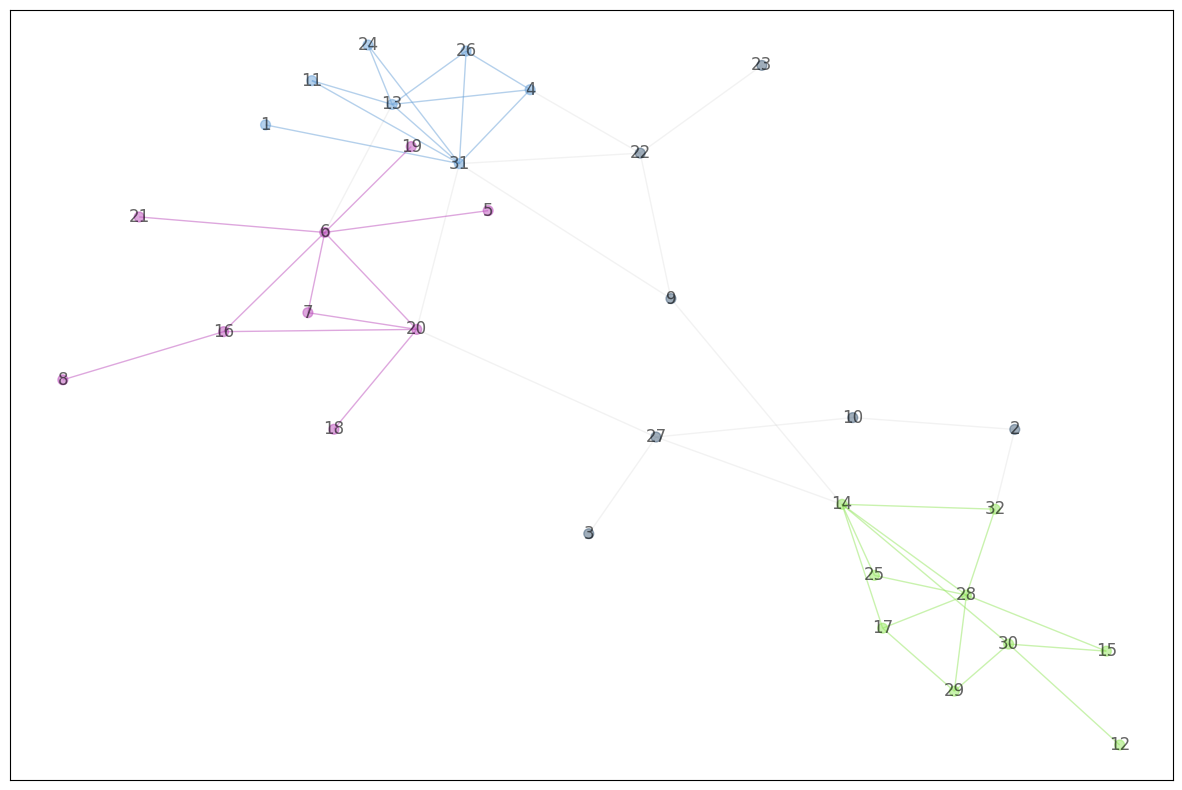

In [94]:
# Draw Community Graph
nx.draw_networkx(graph, pos=pos, node_size=0, edgelist=external, edge_color="silver", alpha=0.2, with_labels=True)
nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, alpha=0.5, with_labels=True)
plt.show()